# Indian Liver Patient Records

Compare performance of [random forest](https://github.com/worasom/indian_liver_patients/blob/master/Indian_liver_patients_random_forest.ipynb), [logistic regression](https://github.com/worasom/indian_liver_patients/blob/master/Indian_liver_logistic.ipynb), and [neural network](https://github.com/worasom/indian_liver_patients/blob/master/Indian_liver_patients-NN.ipynb) performances on identifying liver patients from their blood panel. The traing procedures for each model can be found in the hyperlink.  


This is a kaggle[https://www.kaggle.com/uciml/indian-liver-patient-records/home] competition. The data is from Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science. There are a number of machine learning papers that work on this data set;for example:
- Bendi Venkata Ramana, Prof. M. S. Prasad Babu and Prof. N. B. Venkateswarlu, "A Critical Comparative Study of Liver Patients from USA and INDIA: An Exploratory Analysis", International Journal of Computer Science Issues, (May 2012)
- Bendi Venkata Ramana and Prof. M.Surendra Prasad Babu, "Liver Classification Using Modified Rotation Forest" International Journal of Engineering Research and Development,  (June 2012)



## Outline <a id='outline'></a>

1. [Exploring data](#Exploringdata): 
     - Find missing data, and turn string data into catergory
     - Inspect the number of patients with and without liver disease among [age and gender groups](#genderage)
     - Separate the datainto train and validation set

2. [Random Forest Classifier](#RF): 
     - Loading the model, 
     - [Results](#RF_result): feature of importance, confusion matrix, most correct and most incorrect predictions for each class
     
3. [Logistic Regression](#LR): 
     - Loading the model
     - [Results](#LR_result)
     
3. [Neural Network with FastAI ](#NN): 
     - [Results](#NN_result)
     
4. [Compare different models](#con): 

Questions:
- Compare results from different models
- Compare featuare of importances calculated from different models

In [1]:
# import libraries

import sys
import feather
from pathlib import Path
sys.path.append(r'C:\Users\Benny\fastai\old')

%config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from fastai.dataset import *
from fastai.column_data import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
accuracy_score, log_loss)
from sklearn.model_selection import RandomizedSearchCV

from IPython.display import display

import seaborn as sns
plt.style.use('ggplot')


## Exploring data <a id='Exploringdata'></a>

The data exploration were done previously in [the random forest notebook](#https://github.com/worasom/indian_liver_patients/blob/master/Indian_liver_patients_random_forest.ipynb)

In [2]:
df_raw=pd.read_feather('tmp/liver_patient_raw')
df_raw.head().T

,0,1,2,3,4
Age,65,62,62,58,72
Gender,Female,Male,Male,Male,Male
Total_Bilirubin,0.7,10.9,7.3,1,3.9
Direct_Bilirubin,0.1,5.5,4.1,0.4,2
Alkaline_Phosphotase,187,699,490,182,195
Alamine_Aminotransferase,16,64,60,14,27
Aspartate_Aminotransferase,18,100,68,20,59
Total_Protiens,6.8,7.5,7,6.8,7.3
Albumin,3.3,3.2,3.3,3.4,2.4
Albumin_and_Globulin_Ratio,0.9,0.74,0.89,1,0.4


In [3]:
#replacing the null with median
#Scaling is require for logistic regression and neural network
df, y, nas, mapper = proc_df(df_raw, y_fld='Dataset', do_scale=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
Age                              583 non-null float64
Gender                           583 non-null int8
Total_Bilirubin                  583 non-null float64
Direct_Bilirubin                 583 non-null float64
Alkaline_Phosphotase             583 non-null float64
Alamine_Aminotransferase         583 non-null float64
Aspartate_Aminotransferase       583 non-null float64
Total_Protiens                   583 non-null float64
Albumin                          583 non-null float64
Albumin_and_Globulin_Ratio       583 non-null float64
Albumin_and_Globulin_Ratio_na    583 non-null float64
dtypes: float64(10), int8(1)
memory usage: 46.2 KB


Strong correlation between Direct Bilirubin and Total Bilirubin, Albumin and Total_Proteins, and Aspartate_Aminotransferase and Alamine_Aminotransferase. We might be able to drop these. 

In [5]:
df = df.drop('Albumin_and_Globulin_Ratio_na', axis=1)

In [6]:
# split data into training and validation sets 
idxs = get_cv_idxs(len(df), val_pct=0.25, seed=52)
mask = np.zeros(len(df), dtype=bool)
mask[idxs] = True

In [7]:
#define score report function for RF and LG
def print_score(m):
    y_trn_prob = m.predict_proba(x_trn)
    y_val_prob = m.predict_proba(x_val)
    res = [log_loss(y_trn, y_trn_prob), log_loss(y_val, y_val_prob),
          m.score(x_trn, y_trn), m.score(x_val, y_val)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print('train loss\t val loss \t train accuracy \t val accuracy')
    print(res)

## Random Forest Classifier <a id='RF'></a>

In [8]:
#Loading a trained model 
mrf = pickle.load(open('indian_mrf.sav', 'rb'))

In [9]:
cols_keep = df.columns.drop(['Age','Total_Bilirubin', 'Direct_Bilirubin', 
                              'Alkaline_Phosphotase','Alamine_Aminotransferase' ])

In [10]:
df_rf = df[cols_keep].copy()
df_rf.columns

Index(['Gender', 'Aspartate_Aminotransferase', 'Total_Protiens', 'Albumin',
       'Albumin_and_Globulin_Ratio'],
      dtype='object')

In [11]:
x_trn = df_rf[~mask]
x_val = df_rf[mask]
y_trn = y[~mask]
y_val = y[mask]

In [12]:
print_score(mrf)

train loss	 val loss 	 train accuracy 	 val accuracy
[0.8165205545509419, 0.8696364104556079, 0.7100456621004566, 0.7241379310344828, 0.7077625570776256]


### Analyzing RF Results

In [13]:
from sklearn.metrics import roc_auc_score


In [14]:
fi_rf = rf_feat_importance(mrf, x_trn)
fi_rf

,cols,imp
3,Albumin,0.247583
0,Gender,0.227410
1,Aspartate_Aminotransferase,0.223055
2,Total_Protiens,0.179009
4,Albumin_and_Globulin_Ratio,0.122943


In [15]:
preds = mrf.predict(x_val)
proba = mrf.predict_proba(x_val)
roc_auc_score(y_val, preds)

0.5

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Classification Report validation set: 
               precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00        40
         Ill       0.72      1.00      0.84       105

   micro avg       0.72      0.72      0.72       145
   macro avg       0.36      0.50      0.42       145
weighted avg       0.52      0.72      0.61       145



([<matplotlib.axis.YTick at 0x1767003a048>,
 <a list of 2 Text yticklabel objects>)

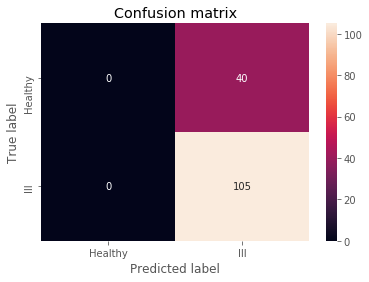

In [16]:
#print('Confusion Matrix: \n', confusion_matrix(y_val,preds))
print('Classification Report validation set: \n', classification_report(y_val,preds, 
                                                        target_names=['Healthy', 'Ill']))

sns.heatmap(confusion_matrix(y_val,preds),annot=True,fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix')
tick_marks = np.arange(2) + 0.5
plt.xticks(tick_marks, ['Healthy','Ill'])
plt.yticks(tick_marks, ['Healthy','Ill'])

In diagnosis, the model should minimize false negative, which is labeling the patients with liver disease as healthy.

We compare the model prediction to normal blood panel analysis. To help analyzing the data, we categorize each blood panel into range labeld low, normal, high. 

In [17]:
features = df_raw.columns.drop(['Age','Gender','Dataset']);features

Index(['Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase',
       'Alamine_Aminotransferase', 'Aspartate_Aminotransferase',
       'Total_Protiens', 'Albumin', 'Albumin_and_Globulin_Ratio'],
      dtype='object')

In [18]:
# blood test normal range
bins_dict = {'Total_Bilirubin': [0, 0.1, 1.2, np.inf],
             'Direct_Bilirubin': [0, 0.3, np.inf],
             'Alkaline_Phosphotase': [0, 20, 140, np.inf],
             'Alamine_Aminotransferase': [0, 10, 40, np.inf],
             'Aspartate_Aminotransferase': [0, 7, 56, np.inf],
             'Total_Protiens': [0, 6, 8.3, np.inf],
             'Albumin': [0, 3.5, 5.5, np.inf],
             'Albumin_and_Globulin_Ratio': [0, 0.8, 2.0, np.inf]
             }

In [19]:
def ana_blood(col):
    """convert each blood panel into catergory"""
    if len(bins_dict[col.name]) == 3:
        labels = ['normal','high']
    else:
        labels = ['low','normal','high'] 
    return pd.cut(col,bins=bins_dict[col.name], labels=labels)

In [20]:
# analyse the validation set
#df_analyse = x_val.copy()
df_analyse = df_raw[mask].copy()
df_analyse.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,ill
7,29,Female,0.9,0.3,202,14,11,6.7,3.6,1.10,ill
8,17,Male,0.9,0.3,202,22,19,7.4,4.1,1.20,healthy
11,72,Male,2.7,1.3,260,31,56,7.4,3.0,0.60,ill
19,40,Female,0.9,0.3,293,232,245,6.8,3.1,0.80,ill


In [21]:
for fea in features:
    df_analyse[fea] = ana_blood(df_analyse[fea])

In [22]:
df_analyse['y_val'] = y_val
df_analyse['prediction'] = preds
df_analyse['predict_proba'] = proba[:,1]
df_analyse['prediction'] = df_analyse['prediction'].astype('category')
df_analyse['prediction']=df_analyse['prediction'].cat.rename_categories({0:'healthy', 1:'ill'})

In [23]:
df_analyse.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset,y_val,prediction,predict_proba
2,62,Male,high,high,high,high,high,normal,low,normal,ill,1,ill,0.944755
7,29,Female,normal,normal,high,normal,normal,normal,normal,normal,ill,1,ill,0.962733
8,17,Male,normal,normal,high,normal,normal,normal,normal,normal,healthy,0,ill,0.962733
11,72,Male,high,high,high,normal,normal,normal,low,low,ill,1,ill,0.900218
19,40,Female,normal,normal,high,high,high,normal,low,low,ill,1,ill,0.910681


In [24]:
def show_result_ex(is_correct, ran, val_preds, y_val):
    """ return random index of correct or in_correct classification"""
    idx = np.where((val_preds == y_val)==is_correct)[0]
    idx = np.random.choice(idx, min(len(idx),6)) if ran==True else idx
    return idx

In [25]:
print('Random example of correctly classified')
df_analyse.iloc[show_result_ex(True, True, preds, y_val)].head()

Random example of correctly classified


,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset,y_val,prediction,predict_proba
289,57,Male,high,high,high,high,high,normal,normal,normal,ill,1,ill,0.982437
113,74,Male,normal,normal,high,normal,high,low,low,low,ill,1,ill,0.790092
469,66,Male,normal,normal,high,normal,normal,low,low,low,ill,1,ill,0.727039
211,42,Male,high,high,high,high,high,normal,low,low,ill,1,ill,0.938001
120,32,Male,high,high,high,high,high,normal,low,normal,ill,1,ill,0.942963


In [26]:
print('Random example of incorrectly classified')
df_analyse.iloc[show_result_ex(False, True, preds, y_val)].head()

Random example of incorrectly classified


,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset,y_val,prediction,predict_proba
33,38,Female,high,high,high,high,high,low,low,low,healthy,0,ill,0.797346
122,58,Male,high,high,high,high,high,low,low,normal,healthy,0,ill,0.908645
33,38,Female,high,high,high,high,high,low,low,low,healthy,0,ill,0.797346
323,12,Male,normal,normal,high,high,high,normal,low,normal,healthy,0,ill,0.958326
342,35,Male,normal,normal,high,normal,normal,normal,normal,normal,healthy,0,ill,0.973590


In [27]:
print('Most Incorrectly classified as Ill')

df_analyse.iloc[show_result_ex(False, False, preds, y_val)
               ][df_analyse['Dataset']=='healthy'].sort_values('predict_proba', 
                                                               ascending=False).head(5)

Most Incorrectly classified as Ill


C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset,y_val,prediction,predict_proba
423,53,Male,high,high,high,high,high,normal,normal,normal,healthy,0,ill,0.979870
344,37,Male,normal,normal,high,high,normal,normal,normal,normal,healthy,0,ill,0.976609
238,35,Female,normal,normal,high,normal,normal,normal,normal,normal,healthy,0,ill,0.976609
534,39,Male,high,high,high,high,high,normal,normal,normal,healthy,0,ill,0.974195
510,37,Female,normal,normal,high,normal,normal,high,normal,normal,healthy,0,ill,0.973590


Incorrectly classified patients are due to many abnormal blood test results. 

## Logistic Regression <a id='LR'></a>

In [28]:
#Loading a trained model 
mlg = pickle.load(open('indian_mlg.pkl', 'rb'))

In [29]:
cols_keep = df.columns.drop(['Gender','Total_Bilirubin'])

df_lg = df[cols_keep].copy()
df_lg.columns

x_trn = df_lg[~mask]
x_val = df_lg[mask]
y_trn = y[~mask]
y_val = y[mask]

In [30]:
fi_lg = pd.DataFrame({'cols': x_trn.columns, 'imp':np.abs(mlg.coef_[0])})
fi_lg = fi_lg.sort_values('imp', ascending=False)
fi_lg

,cols,imp
0,Age,1.435046
1,Direct_Bilirubin,1.335053
2,Alkaline_Phosphotase,0.710906
3,Alamine_Aminotransferase,0.443639
4,Aspartate_Aminotransferase,0.363857
5,Total_Protiens,0.285693
6,Albumin,0.261359
7,Albumin_and_Globulin_Ratio,0.194382


Classification Report validation set: 
               precision    recall  f1-score   support

     Healthy       0.41      0.40      0.41        40
         Ill       0.77      0.78      0.78       105

   micro avg       0.68      0.68      0.68       145
   macro avg       0.59      0.59      0.59       145
weighted avg       0.67      0.68      0.67       145



([<matplotlib.axis.YTick at 0x17670137160>,
 <a list of 2 Text yticklabel objects>)

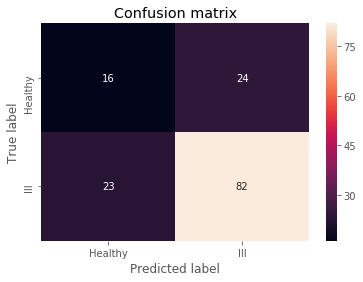

In [31]:
preds = mlg.predict(x_val)
proba = mlg.predict_proba(x_val)

#print('Confusion Matrix: \n', confusion_matrix(y_val,preds))
print('Classification Report validation set: \n', classification_report(y_val,preds, 
                                                        target_names=['Healthy', 'Ill']))

sns.heatmap(confusion_matrix(y_val,preds),annot=True,fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix')
tick_marks = np.arange(2) + 0.5
plt.xticks(tick_marks, ['Healthy','Ill'])
plt.yticks(tick_marks, ['Healthy','Ill'])

In [32]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_val, preds)

0.5904761904761904

In [33]:
df_analyse['prediction'] = preds
df_analyse['predict_proba'] = proba[:,1]
df_analyse['prediction'] = df_analyse['prediction'].astype('category')
df_analyse['prediction']=df_analyse['prediction'].cat.rename_categories({0:'healthy', 1:'ill'})

In [34]:
print('Most Incorrectly classified as Ill')

df_analyse.iloc[show_result_ex(False, False, preds, y_val)
               ][df_analyse['Dataset']=='healthy'].sort_values('predict_proba', 
                                                               ascending=False).head(5)

Most Incorrectly classified as Ill


C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset,y_val,prediction,predict_proba
44,85,Female,normal,normal,high,normal,normal,normal,normal,normal,healthy,0,ill,0.991798
78,70,Male,high,high,high,normal,normal,normal,normal,normal,healthy,0,ill,0.974872
114,50,Male,high,high,high,high,high,low,low,low,healthy,0,ill,0.963438
403,65,Male,normal,normal,high,normal,normal,normal,normal,normal,healthy,0,ill,0.950249
215,66,Male,normal,normal,normal,normal,high,low,low,normal,healthy,0,ill,0.944671


In [35]:
print('Most Incorrectly classified as Healthy')

df_analyse.iloc[show_result_ex(False, False, preds, y_val)
               ][df_analyse['Dataset']=='ill'].sort_values('predict_proba', 
                                                               ascending=False).head(5)

Most Incorrectly classified as Healthy


C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset,y_val,prediction,predict_proba
350,37,Male,high,high,high,high,high,low,low,normal,ill,1,healthy,0.490582
502,42,Male,normal,normal,normal,normal,normal,low,low,normal,ill,1,healthy,0.489581
352,26,Female,normal,normal,high,normal,normal,normal,normal,normal,ill,1,healthy,0.477460
7,29,Female,normal,normal,high,normal,normal,normal,normal,normal,ill,1,healthy,0.448635
479,33,Male,high,high,high,high,high,normal,low,low,ill,1,healthy,0.423715


False negative has a low probability. 

## Neural Network with FastAI<a id='NN'></a>

In [36]:
# split data into training and validation sets 
idxs = get_cv_idxs(len(df), val_pct=0.25, seed=52)
mask = np.zeros(len(df), dtype=bool)
mask[idxs] = True

md = ColumnarModelData.from_data_frame('', val_idxs=idxs, df=df, y=y.astype(np.int64), cat_flds=['Gender'], is_reg=False,
                                      bs=512)
cat_vars = ['Gender']
cat_sz = [(c, len(df_raw[c].cat.categories)+1) for c in cat_vars]; cat_sz
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]; 
mnn = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, out_sz=2, szs=[200, 20], drops=[0.001, 0.01], y_range=None)

In [37]:
mnn.load('indian_mnn')

In [38]:
#https://medium.com/@mp.music93/neural-networks-feature-importance-with-fastai-5c393cf65815
def nn_feat_importance(m, md, cat_vars, cont_vars):
    """ Computes the feature importance for each categorical and continuous column
    m is a fastai.column_data.StructuredLearner
    md is a fastai.column_data.ColumnarModelData
    cat_vars is a list with the categorical vars names as used to define m and md
    cont_vars is a list with the continuous vars names as used to define m and md
    """
    loss0 = np.array([to_np(m.crit(m.model(x_cat, x_cont), y)) for x_cat, x_cont, y in iter(md.val_dl)]).mean()
    fi = dict()
    for i, c in enumerate(cat_vars):
        loss = []
        for x_cat, x_cont, y in iter(md.val_dl):
            rnd = T(np.random.permutation(x_cat.size()[0]))
            x_cat[:, i] = x_cat[rnd, i]
            loss.append(to_np(m.crit(m.model(x_cat, x_cont), y)))
        fi[c] = np.mean(loss) - loss0
    for i, c in enumerate(cont_vars):
        loss = []
        for x_cat, x_cont, y in iter(md.val_dl):
            rnd = T(np.random.permutation(x_cat.size()[0]))
            x_cont[:, i] = x_cont[rnd, i]
            loss.append(to_np(m.crit(m.model(x_cat, x_cont), y)))
        fi[c] = np.mean(loss) - loss0
    d = sorted(fi.items(), key=lambda kv: kv[1], reverse=True)
    return pd.DataFrame({'cols': [l for l, v in d], 'imp': np.log1p([v for l, v in d])})


In [39]:
con_vars = df.columns.drop(cat_vars)
finn = nn_feat_importance(mnn, md, cat_vars, con_vars)
finn

,cols,imp
0,Aspartate_Aminotransferase,0.029920
1,Alamine_Aminotransferase,0.021836
2,Total_Bilirubin,0.014830
3,Alkaline_Phosphotase,0.003737
4,Age,0.003612
5,Direct_Bilirubin,0.001888
6,Albumin,-0.003054
7,Gender,-0.005688
8,Total_Protiens,-0.008043
9,Albumin_and_Globulin_Ratio,-0.011456


In [40]:
log_preds = mnn.predict()
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds)

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\sklearn\metrics\classification.py:1537: UserWarning: labels size, 1, does not match size of target_names, 2
  .format(len(labels), len(target_names))


Classification Report validation set: 
               precision    recall  f1-score   support

     Healthy       0.72      1.00      0.84       105

   micro avg       0.72      1.00      0.84       105
   macro avg       0.72      1.00      0.84       105
weighted avg       0.72      1.00      0.84       105



([<matplotlib.axis.YTick at 0x17607372978>,
 <a list of 2 Text yticklabel objects>)

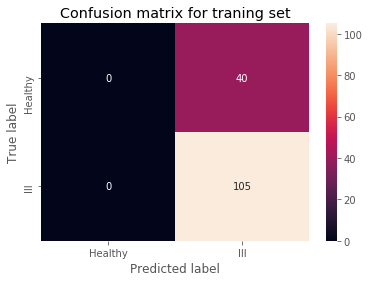

In [41]:
print('Classification Report validation set: \n', classification_report(y_val,preds, 
                                                        target_names=['Healthy', 'Ill'], labels=np.unique(preds)))

sns.heatmap(confusion_matrix(y_val,preds),annot=True,fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for traning set')
tick_marks = np.arange(2) + 0.5
plt.xticks(tick_marks, ['Healthy','Ill'])
plt.yticks(tick_marks, ['Healthy','Ill'])

In [42]:
roc_auc_score(y_val, preds)

0.5

In [43]:
df_analyse['y_val'] = y_val
df_analyse['prediction'] = preds
df_analyse['predict_proba'] = proba[:,1]
df_analyse['prediction'] = df_analyse['prediction'].astype('category')
df_analyse['prediction']=df_analyse['prediction'].cat.rename_categories({0:'healthy', 1:'ill'})

In [44]:
print('Most Incorrectly classified as Ill')

df_analyse.iloc[show_result_ex(False, False, preds, y_val)
               ][df_analyse['Dataset']=='healthy'].sort_values('predict_proba', 
                                                               ascending=False).head(5)

Most Incorrectly classified as Ill


C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset,y_val,prediction,predict_proba
44,85,Female,normal,normal,high,normal,normal,normal,normal,normal,healthy,0,ill,0.991798
78,70,Male,high,high,high,normal,normal,normal,normal,normal,healthy,0,ill,0.974872
114,50,Male,high,high,high,high,high,low,low,low,healthy,0,ill,0.963438
403,65,Male,normal,normal,high,normal,normal,normal,normal,normal,healthy,0,ill,0.950249
215,66,Male,normal,normal,normal,normal,high,low,low,normal,healthy,0,ill,0.944671


## Compare different models <a id='con'></a>

Compare feature of importances

In [45]:
fi_rf.set_index('cols',inplace=True)
finn.set_index('cols', inplace=True)
fi_lg.set_index('cols',inplace=True);

In [46]:
fi_all = finn.merge(fi_rf, on = 'cols', how='outer', suffixes=['_nn','_rf'] )
fi_all = fi_all.merge(fi_lg, on = 'cols', how='outer', suffixes=['','_lg'])
fi_all.sort_values('imp', ascending=False, inplace=True)

In [47]:
fi_all = fi_all.apply(lambda x: x/np.max(x), axis=0 )

In [48]:
fi_all

,imp_nn,imp_rf,imp
cols,,,
Age,0.120707,NaN,1.000000
Direct_Bilirubin,0.063101,NaN,0.930321
Alkaline_Phosphotase,0.124899,NaN,0.495389
Alamine_Aminotransferase,0.729812,NaN,0.309146
Aspartate_Aminotransferase,1.000000,0.900928,0.253551
Total_Protiens,-0.268820,0.723025,0.199083
Albumin,-0.102058,1.000000,0.182126
Albumin_and_Globulin_Ratio,-0.382899,0.496571,0.135454
Total_Bilirubin,0.495656,NaN,NaN


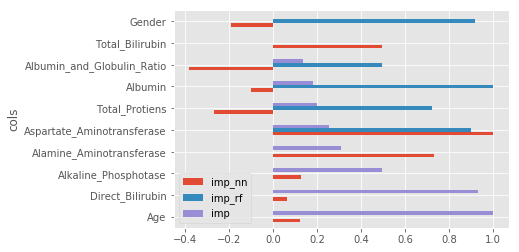

In [49]:
fi_all.plot(use_index=True, kind='barh')

Logistic regression perform best with accuracly 77% and ROC 0.6 on the validation set. RF and NN models seems to overfit by considering all health patient as ill; however, the false positive patients in RF models does have abnormal blood test, while NN model classify many healthy patients with normal blood test as ill. In theory, NN model should be as good as or better than the logistic regression. Here, we may need more data to train the network. 

Each model has different feature of importance. All models agree that "Asparatate_Amonotransferase" is an important feature. 